# Modelos base

## Contenido

1. [k-Nearest Neighbors](#k-Nearest-Neighbors)
2. [Regresión logística](#Regresión-logística)
3. [Arbol de Desición](#Arbol-de-desición)
4. [Clasificación Bayesiana](#Clasificación-Bayesiana)
5. [Comparación de Modelos](#Comparación-de-Modelos)

Cabe resaltar que todos los Scripts usados se pueden observar en la carpeta *Scripts* del repositorio. Los correspondientes a este capítulo son *gen_models.py* para la generación de los modelos y *classification.py* para la búsqueda por hiperparámetros generalizada. Cabe resaltar que esta se realizó por medio de un `BayesSearchCV` obtenida del paquete de scikit-learn *scikit-optimize* o *skopt*, de modo que es necesario almacenar a su vez los respectivos espacios de búsqueda para la función. Todos los modelos se entrenaron tanto con el dataset base como el balanceado, además, algunos de ellos incluyeron una estandarización y un análisis de componentes principales para mejorar los resultados del modelo, para comparar como estos afectan el puntaje del modelo.

Por otro lado, el PCA es necesario aplicarlo dentro del pipeline dado que, al usar todos los datos para hallar las componentes principales, puede causar fuga de datos dentro del set a la hora de la búsqueda de parámetros de la misma forma que una estandarización puede causarla. Finalmente, es necesario aplicar el PCA posterior a la estandarización ya que la uniformidad de las varianzas para cada una de las variables respuesta es necesaria para evitar que la diferencia entre estas lleve a pérdida de información. Recordemos que las pendientes de las componentes principales se ajustan a la mayor varianza explicada, por lo que si hay diferencias marcadas entre las varianzas de distintas variables, la componente principal no representará adecuadamente a los datos.

In [1]:
# Importación de librerías
import os
import sys

from pandas import DataFrame
from numpy import array

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from skopt.space import Real, Integer, Categorical

proyect = os.path.abspath('../..')
if proyect not in sys.path:
    sys.path.append(proyect)
from Improved.models_testing import evaluate_model, plot_confusion_matrix, plot_predictions, plot_roc_curve, plot_feature_importances, get_predictions

Importación de modelos ya entrenados:

In [2]:
import os
from pickle import load, UnpicklingError

with open('../../Models/model_list.txt', 'r') as file:
    model_filenames = file.read().splitlines()

models = []
for model_name in model_filenames:
    model_path = os.path.join('../../Models', f'{model_name}.pkl')
    print(f"Attempting to load model from: {model_path}")
    if os.path.exists(model_path):
        try:
            with open(model_path, 'rb') as model_file:
                model = load(model_file)
                models.append(model)
                print(f"Successfully loaded model: {model_name}")
        except (UnpicklingError, EOFError, OSError, Exception) as e:
            print(f"Error loading {model_path}: {e}")
    else:
        print(f"File {model_path} does not exist.")

Attempting to load model from: ../../Models\Logistic Base.pkl
Successfully loaded model: Logistic Base
Attempting to load model from: ../../Models\Logistic Balanced.pkl
Successfully loaded model: Logistic Balanced
Attempting to load model from: ../../Models\Logistic PCA Base.pkl
Successfully loaded model: Logistic PCA Base
Attempting to load model from: ../../Models\Logistic PCA Balanced.pkl
Successfully loaded model: Logistic PCA Balanced
Attempting to load model from: ../../Models\KNN Base.pkl
Successfully loaded model: KNN Base
Attempting to load model from: ../../Models\KNN Balanced.pkl
Successfully loaded model: KNN Balanced
Attempting to load model from: ../../Models\KNN PCA Base.pkl
Successfully loaded model: KNN PCA Base
Attempting to load model from: ../../Models\KNN PCA Balanced.pkl
Successfully loaded model: KNN PCA Balanced
Attempting to load model from: ../../Models\Descicion Tree Base.pkl
Successfully loaded model: Descicion Tree Base
Attempting to load model from: ../../

In [3]:
with open( '../../Models/data_models.pkl', 'rb' ) as f:
    data = load( f )
X_test, y_test = data['train']
X_test, y_test = X_test.copy(), y_test.copy()

## k-Nearest Neighbors

Dado que el algoritmo $k$-NN depende fuertemente de las distancias, es necesario estandarizar cada variable de modo que ninguna variable opaque a otra con un rango extremadamente pequeño, ya que este algoritmo se basa en distancias entre variables.

In [4]:
knn = {
    'name': 'KNN',
    'pipe': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', KNeighborsClassifier())
    ]),
    'search_spaces': {
        'classifier__n_neighbors': Integer( 1, 400 ),
        'classifier__weights': Categorical( [ 'uniform', 'distance' ] )
    }
}

knn_pca = {
    'name': 'KNN PCA',
    'pipe': Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(0.9)),
        ('classifier', KNeighborsClassifier())
    ]),
    'search_spaces': {
        'classifier__n_neighbors': Integer( 1, 400 ),
        'classifier__weights': Categorical( [ 'uniform', 'distance' ] )
    }
}

En la siguiente tabla podemos observar más de cerca los modelos después de la hiperparametrización.

In [5]:
knn_models = models[ 4:8 ]
parameters = [ 
        { 'Nombre': model_filenames[ 4 + i ] } | 
        model['model'].best_params_ | 
        { 'AUC': model['model'].best_score_, 'Tiempo de CPU': model['cpu_time'] } 
    for i, model in enumerate(knn_models) 

]
parameters = DataFrame( parameters )
parameters

,Nombre,classifier__n_neighbors,classifier__weights,AUC,Tiempo de CPU
0,KNN Base,59,uniform,0.742910,1925.500179
1,KNN Balanced,53,distance,0.753952,942.796789
2,KNN PCA Base,55,uniform,0.741183,437.227390
3,KNN PCA Balanced,37,distance,0.750647,359.124776


Es notorio que los tres primeros tengan un número de vecinos extremadamente cercano, mientras que el último modelo posee un k mucho más bajo, cosa que se puede atribuir al método de hiperparametrización, ya que al ser aleatoreo, pudo haber recorrido puntos lejanos al que el resto de modelos encontraron como certeros.

Por otro lado, podemos apreciar que aquellos entrenados con un dataset desbalanceado encontraron mejor aplicar un $k$-NN base, mientras que los modelos balanceados encontraron mejor aplicar pesos según la distancia al sistema de votación, asignando un mayor voto mientras más cercana se encuentre la observación del punto.

En última instancia cabe resaltar la gran diferencia de tiempo, tanto balanceando, como aplicando un PCA, ya que la diferencia entre el primer y último modelo es de aproximadamente 5 veces, en la [comparación de modelos](#Comparación-de-Modelos) se verá si esta diferencia de tiempo no resulta en una pérdida significativa de desempeño.

A continuación podemos ver las curvas ROC de los modelos y su mejor umbral para la predicción.

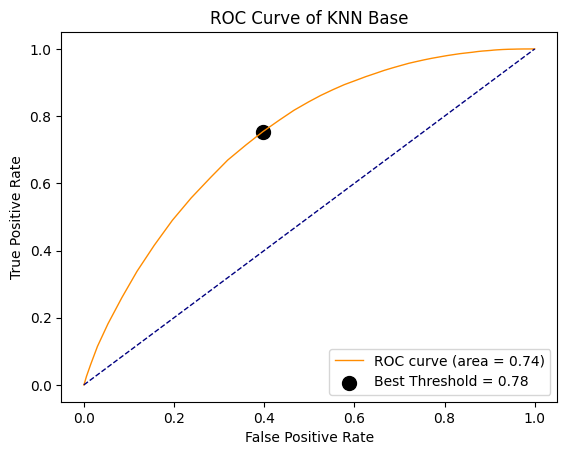

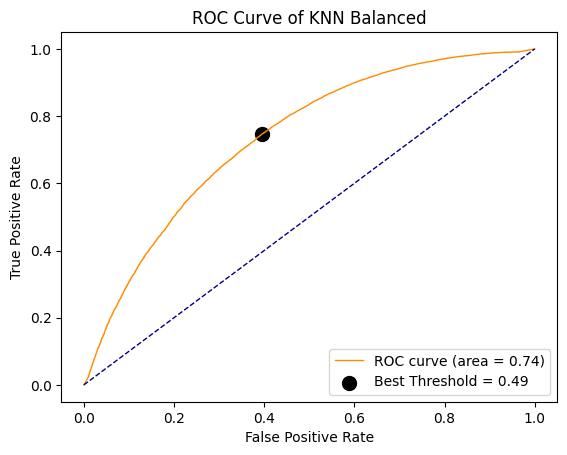

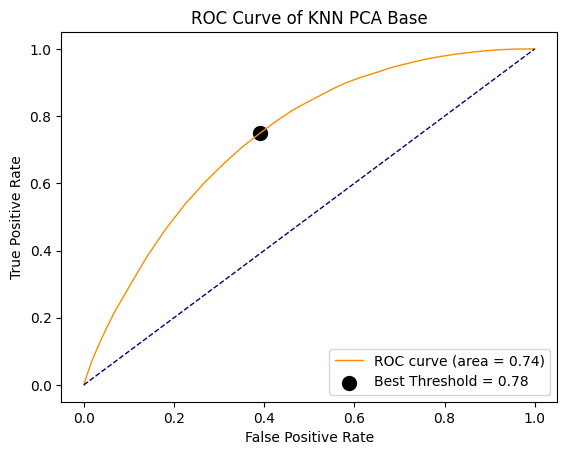

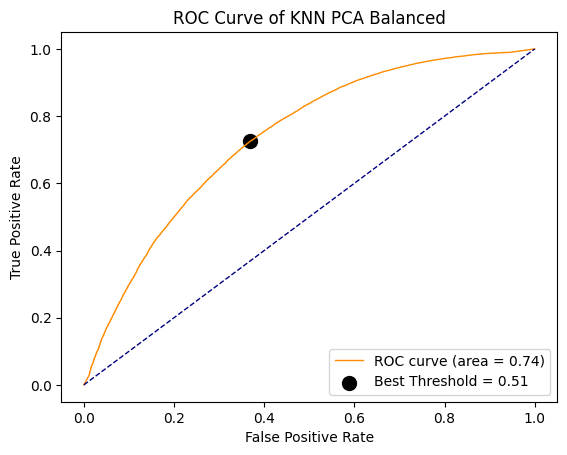

In [6]:
for idx, row in parameters.iterrows():
    model = models[ 4 + idx ]['model']
    model_name = row['Nombre']
    plot_roc_curve(model, X_test, y_test, model_name)

Con estos humbrales en cuenta, podemos ver las matrices de confución de cada modelo.

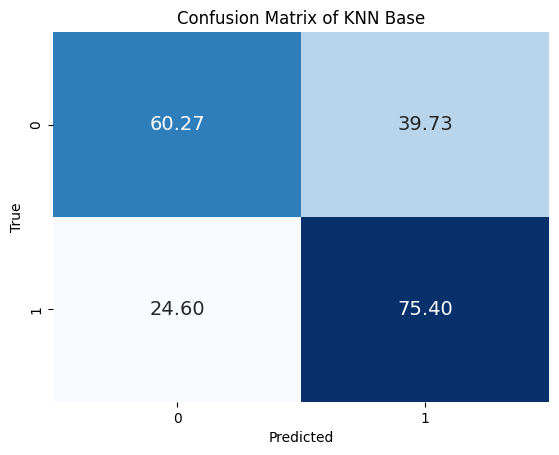

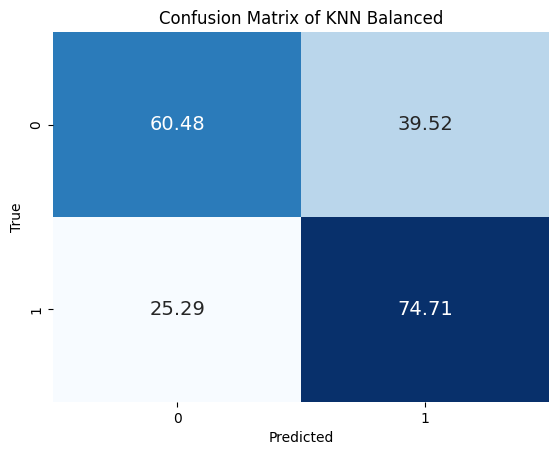

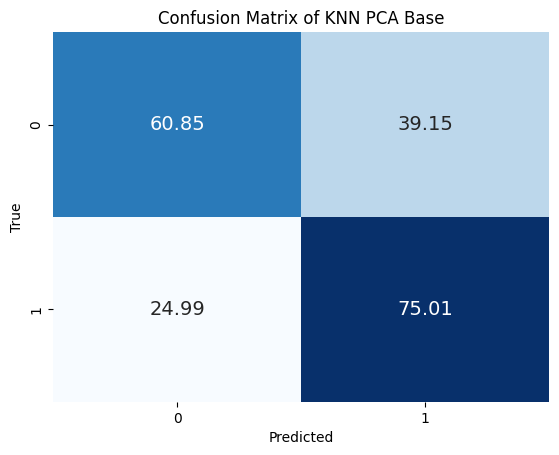

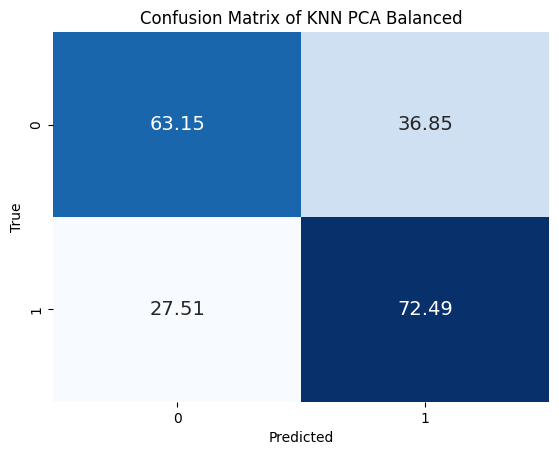

In [7]:
for idx, row in parameters.iterrows():
    model = models[ 4 + idx ]['model']
    model_name = row['Nombre']
    plot_confusion_matrix(model, X_test, y_test, model_name)

Cabe resaltar que los gráficos representan los porcentajes según el verdadero valor de la variable.
Podemos notar que en general, los modelos tuvieron un desempeño similar, clasificando correctamente la mayoría de variables. Aún así, este modelo tuvo un mejor desempeño clasificando correctamente los valores de 1 que de 0 en todos los casos.

## Regresión logística

A diferencia del modelo anterior, no es necesaria la estandarización de los datos para el entrenamiento del modelo, sin embargo, dado que la estandarización no lleva a pérdida de la información, no hay problema alguno en mantenerlo para continuar con un sentido de uniformidad entre la definición de los modelos.

In [8]:
lr = {
    'name': 'Logistic',
    'pipe': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression( solver='saga', max_iter=1000 ) )
    ]),
    'search_spaces': {
        'classifier__penalty': Categorical( [ 'l1', 'l2' ] ),
        'classifier__C': Real(1e-4, 1e+4, prior='log-uniform')
    }
}

lr_pca = {
    'name': 'Logistic PCA',
    'pipe': Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(0.9)),
        ('classifier', LogisticRegression( solver='saga', max_iter=1000 ) )
    ]),
    'search_spaces': {
        'classifier__penalty': Categorical( [ 'l1', 'l2' ] ),
        'classifier__C': Real(1e-4, 1e+4, prior='log-uniform')
    }
}

A continuación podemos observar los resultados de la hiperparametrización.

In [9]:
lr_models = models[ 0:4 ]
parameters = [ 
        { 'Nombre': model_filenames[ i ] } | 
        model['model'].best_params_ | 
        { 'AUC': model['model'].best_score_, 'Tiempo de CPU': model['cpu_time'] } 
    for i, model in enumerate(lr_models) 

]
parameters = DataFrame( parameters )
parameters

,Nombre,classifier__C,classifier__penalty,AUC,Tiempo de CPU
0,Logistic Base,0.080112,l1,0.645170,3484.632594
1,Logistic Balanced,153.112474,l1,0.654523,8085.255974
2,Logistic PCA Base,9953.739303,l2,0.605373,5159.598865
3,Logistic PCA Balanced,10000.000000,l2,0.618090,2013.703079


Dado que la interpretabilidad de los coeficientes para el PCA no es entendible, a continuación se muestra una tabla para los coeficientes de los modelos sin PCA

In [10]:
coefs = array([ model['model'].best_estimator_[-1].coef_[0] for model in lr_models[:2] ])
coef_df = DataFrame( coefs.T, X_test.columns )
coef_df.T

,loan_amount,loan_to_value_ratio,loan_term,property_value,income,ffiec_msa_md_median_family_income,construction_method_Manufactured home,construction_method_Site-built,aus_GUS_0,aus_GUS_1
0,0.91566,-0.374603,-0.065844,-2.162207,-0.003656,-0.093739,-0.072603,0.072603,-0.019378,0.019378
1,0.86250,-0.353272,-0.058847,-3.604570,-0.003385,-0.090697,-0.088653,0.088653,-0.014373,0.014373


A diferencia del modelo anterior, cuyos scores estaban relativamente cercanos unos de otros, hay una diferencia marcada entre los modelos que hicieron uso de un PCA, reduciendo el score en aproximadamente 4 puntos. También es sorpresa que el modelo que más llevó tiempo fue el modelo balanceado, a diferencia del caso anterior, tanto esto como aplicar un PCA por separado llevó a un incremento del tiempo a comparación con el modelo base. 

Por otro lado, el modelo más rapido hizo uso de estas dós técnicas por separado, pero cabe resaltar que tuvo una aparente pérdida de desempeño. Otra diferencia clara es cómo hay una penalización preferida para según si se aplica un PCA o no, y que la constante de regularización es relativamente mayor cuando se trabaja con un dataset balanceado. Por último, podemos ver que los coeficientes entre los dos modelos sin PCA son relativamente similares, presentando diferencias mínimas entre los coeficientes.

A continuación se pueden observar las curvas ROC y las matrices de confución del modelo.

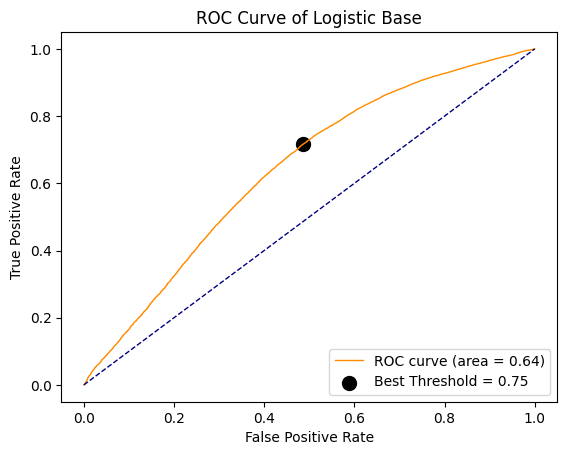

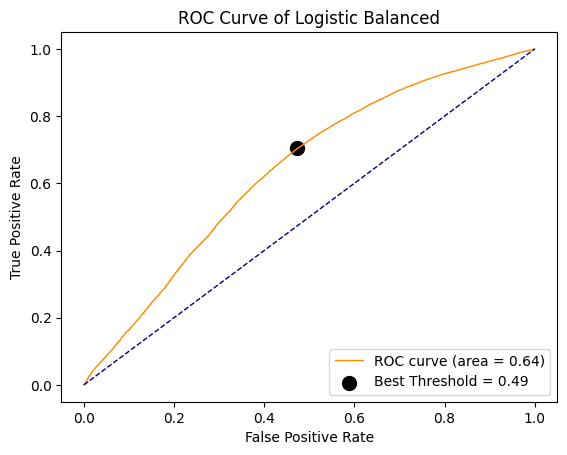

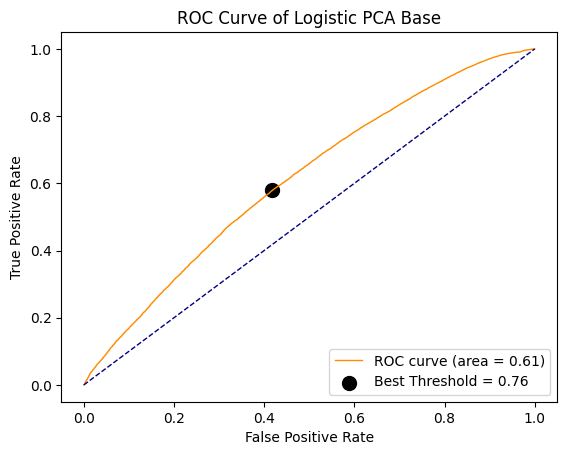

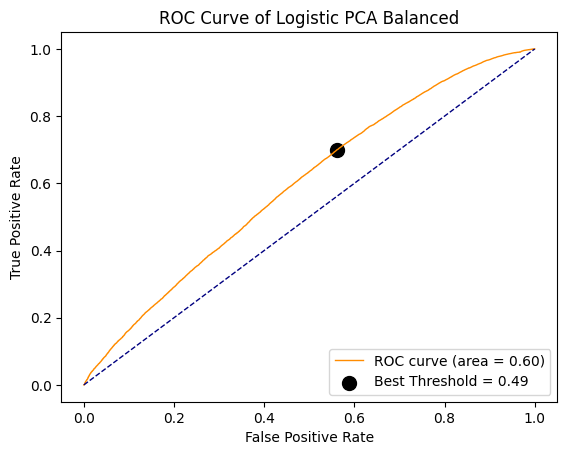

In [11]:
for idx, row in parameters.iterrows():
    model = models[ idx ]['model']
    model_name = row['Nombre']
    plot_roc_curve(model, X_test, y_test, model_name)

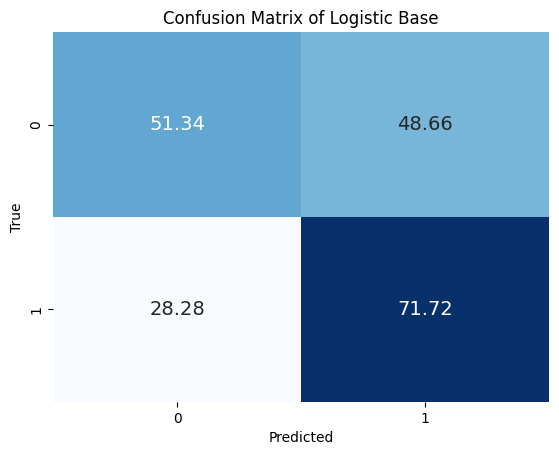

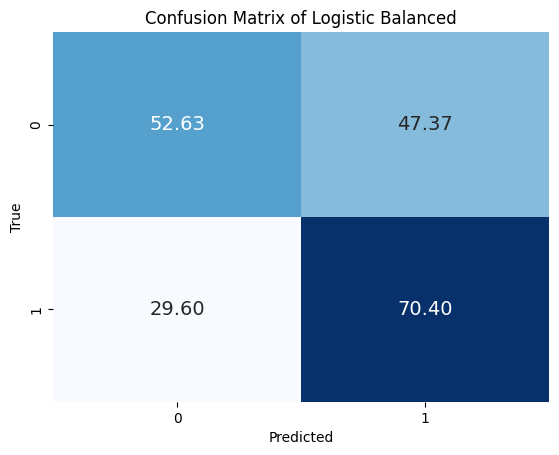

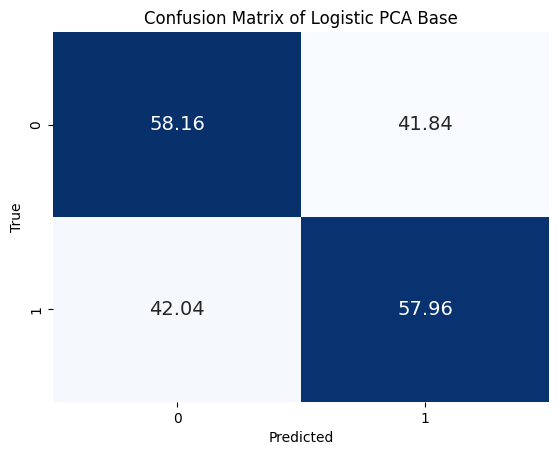

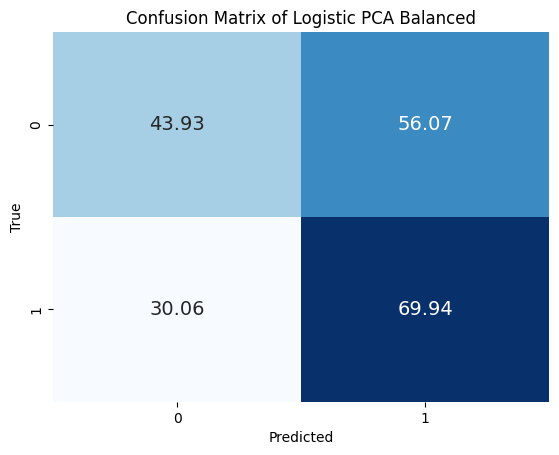

In [12]:
for idx, row in parameters.iterrows():
    model = models[ idx ]['model']
    model_name = row['Nombre']
    plot_confusion_matrix(model, X_test, y_test, model_name)

En este caso podemos ver por qué los puntajes de los modelos son tan bajos; Todos tienen dificultad clasificando las observaciones 0 adecuadamente, clasificando incorrectamente la mayoría en la última observación. En general, obtuvo un peor desempeño que el modelo anterior, independientemente del preprocesamiento de los datos.

## Arbol de Desición

A diferencia de los modelos anteriores, los árboles de desición no aumentan significativamente el tiempo de entrenamiento dada la inclusión de profundidades máximas, por lo que el uso de un PCA es irrelevante para el modelo, perdiendo información sin un impacto significativo en el tiempo de entrenamiento. Por esta razón, no es necesario aplicar ni estandarización ni un PCA al modelo.

In [13]:
dt = {
    'name': 'Descicion Tree',
    'pipe': Pipeline([
        ('classifier', DecisionTreeClassifier())
    ]),
    'search_spaces': {
        'classifier__max_depth': Integer( 4, 8 ),
        'classifier__criterion': Categorical( [ 'gini', 'entropy' ] )
    }
}

In [14]:
dt_models = models[ 8:10 ]
parameters = [ 
        { 'Nombre': model_filenames[ 8+i ] } | 
        model['model'].best_params_ | 
        { 'AUC': model['model'].best_score_, 'Tiempo de CPU': model['cpu_time'] } 
    for i, model in enumerate(dt_models) 

]
parameters = DataFrame( parameters )
parameters

,Nombre,classifier__criterion,classifier__max_depth,AUC,Tiempo de CPU
0,Descicion Tree Base,entropy,8,0.734083,79.125488
1,Descicion Tree Balanced,gini,8,0.745077,76.296319


Es considerable el hecho que este ha sido el modelo con mejor rendimiento, teniendo un tiempo de CPU extremadamente bajo con respecto al reso y un AUC similar a los mejores antes vistos. Nótese que ambos tienen una profundiad máxima de 8, por lo que es posible obtener mejores resultados aumentando la profundidad en el rango de búsqueda, aunque esto puede llevar al sobre ajuste de los datos.

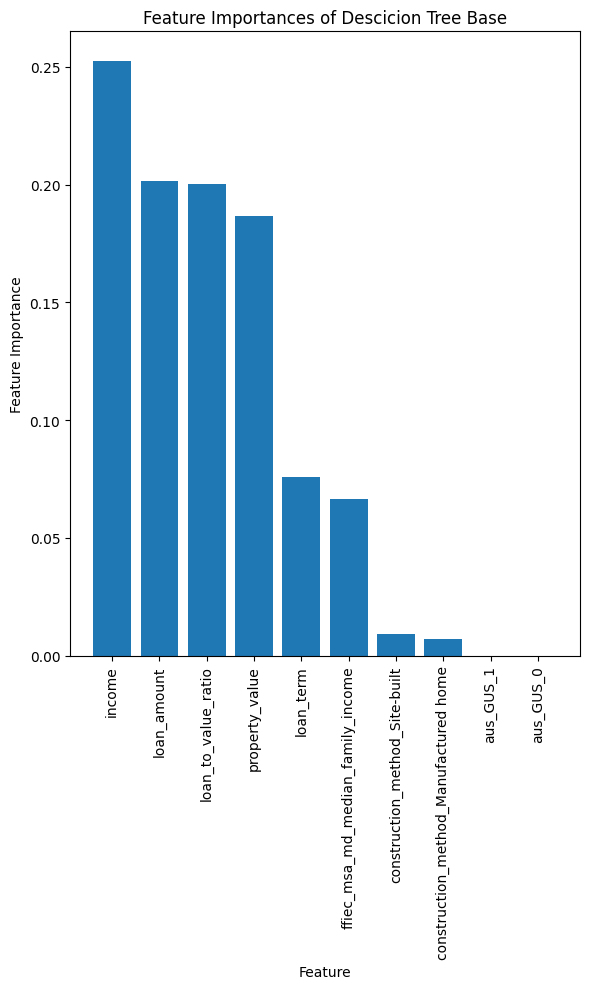

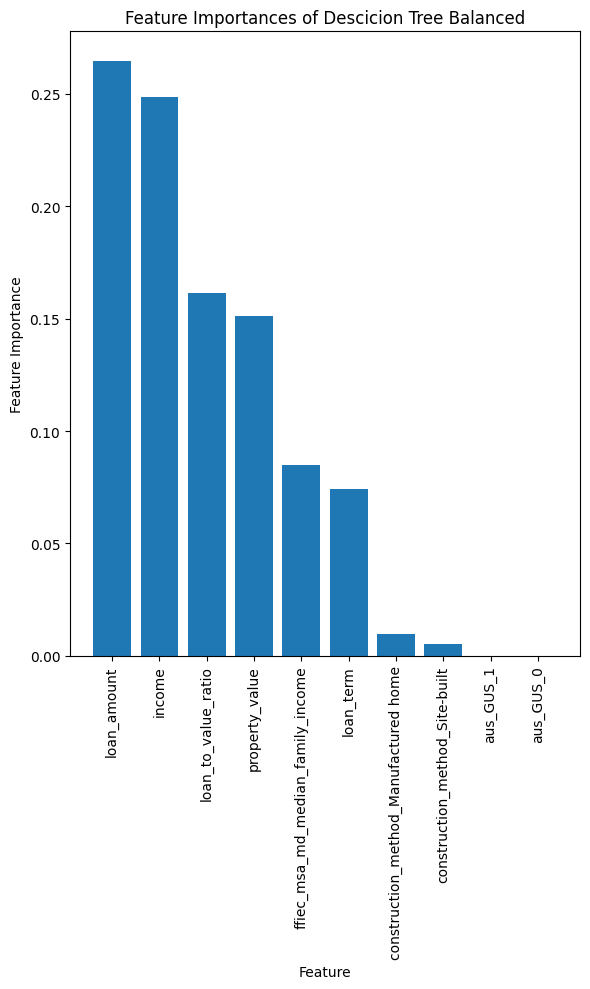

In [15]:
for idx, row in parameters.iterrows():
    model = models[ 8 + idx ]['model']
    model_name = row['Nombre']
    plot_feature_importances( model.best_estimator_[-1], X_test.columns , model_name)

Podemos observar que ambos mantuvieron una selección de variables muy similar, teniendo como mas importantes los ingresos y el valor del préstamo, mientras que no tuvo mucha importancia si presentó o no un sistema GUS para el prestamo. En general, no hubo cambios significativos en la selección de variables a tener en cuenta. De la tabla anterior podemos concluir que su selección pudo diferir gracias a que ambos usaron definiciones de entropía diferentes para las variables, o bien directamente por el desbalance de los datos.

A continuación podemos aprecial las curvas ROC y las matrices de confusión de los modelos resultantes.

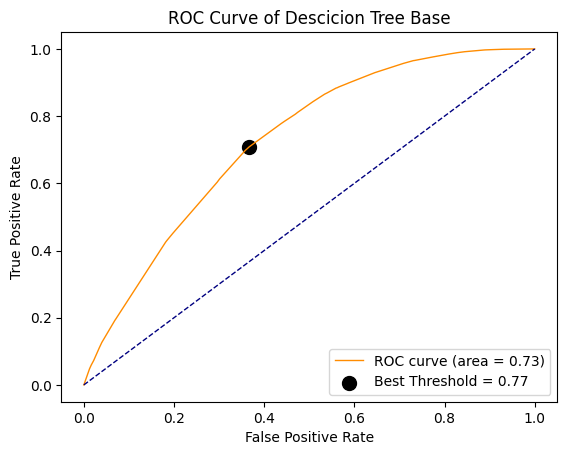

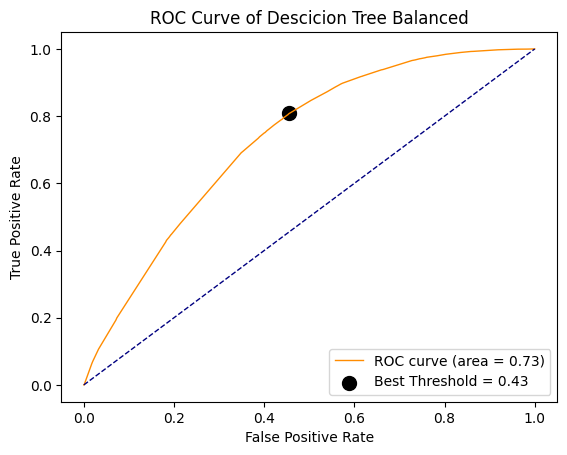

In [16]:
for idx, row in parameters.iterrows():
    model = models[ 8 + idx ]['model']
    model_name = row['Nombre']
    plot_roc_curve(model, X_test, y_test, model_name)

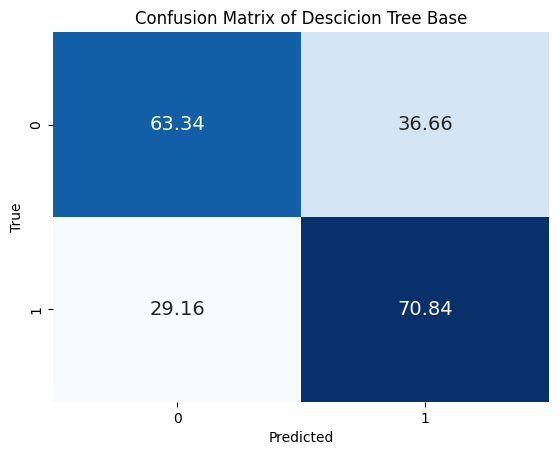

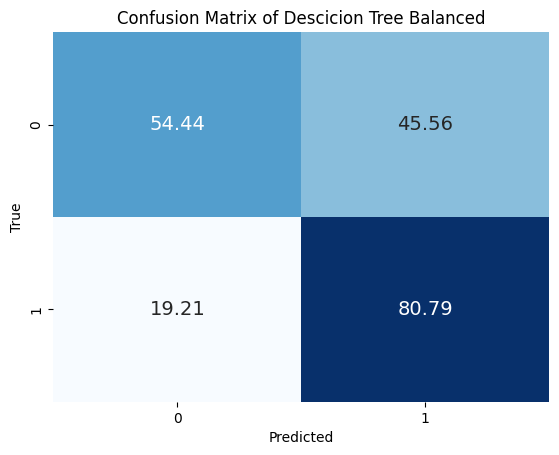

In [17]:
for idx, row in parameters.iterrows():
    model = models[ 8 + idx ]['model']
    model_name = row['Nombre']
    plot_confusion_matrix(model, X_test, y_test, model_name)

Curiosamente, el modelo balanceado tuvo más problemas clasificando la categoría minoritaria correctamente, mientras que fue excelente para clasificar la clase maoyoritaria, con el mayor porcentaje hasta ahora. Por otro lado, el modelo entrenado con los datos desbalanceados obtuvo un balance mayor para la clasificación entre ambas clases.

## Clasificación Bayesiana

In [18]:
bayes = {
    'name': 'Bayesian',
    'pipe': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', BernoulliNB())
    ]),
    'search_spaces': None
}

bayes_pca = {
    'name': 'Bayesian PCA',
    'pipe': Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(0.9)),
        ('classifier', BernoulliNB())
    ]),
    'search_spaces': None
}

In [19]:
nb_models = models[ 10: ]
parameters = [ 
        { 'Nombre': model_filenames[ 10+i ], 'Tiempo de CPU': model['cpu_time'] } 
    for i, model in enumerate(nb_models) 

]
parameters = DataFrame( parameters )
parameters

,Nombre,Tiempo de CPU
0,Bayesian Base,0.321328
1,Bayesian Balanced,0.077787
2,Bayesian PCA Base,0.200281
3,Bayesian PCA Balanced,0.087796


Dado que la clasificación bayesiana no tiene hiperparámetros, el tiempo de entrenamiento es increíblemente corto, en la sección de comparación de modelos podremos observar mejor el desempeño de estos modelos. A continuación podemos observar las curvas ROC y las matrices de confusión para cada modelo.

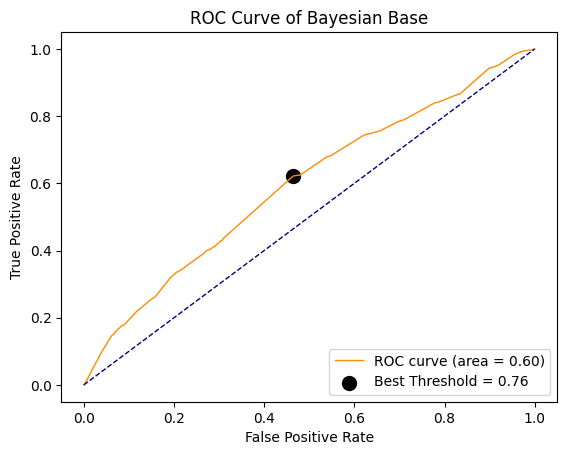

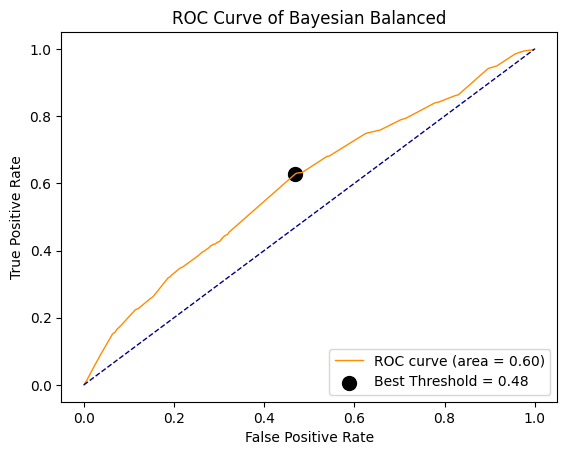

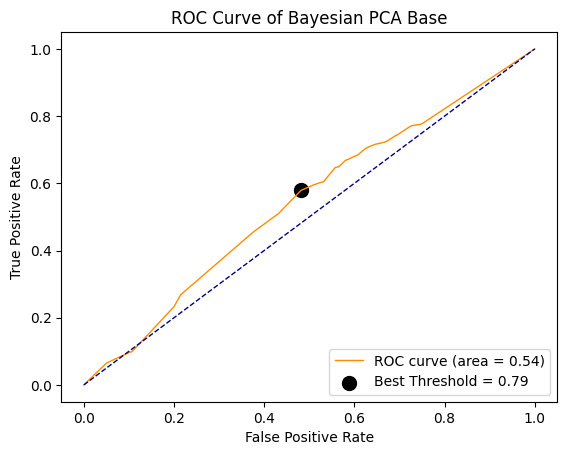

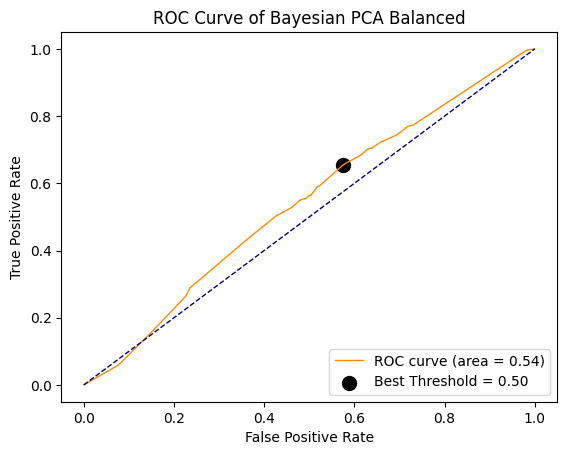

In [20]:
for idx, row in parameters.iterrows():
    model = models[ 10 + idx ]['model']
    model_name = row['Nombre']
    plot_roc_curve(model, X_test, y_test, model_name)

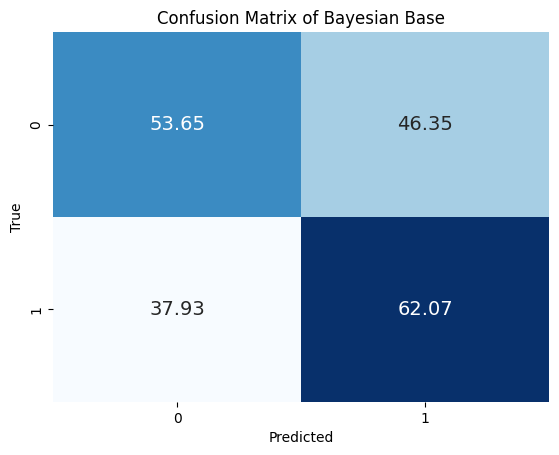

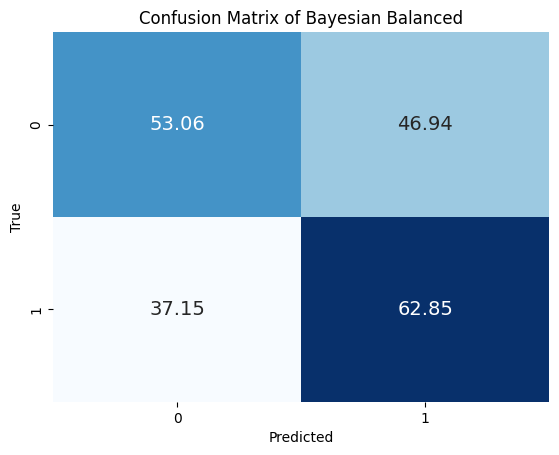

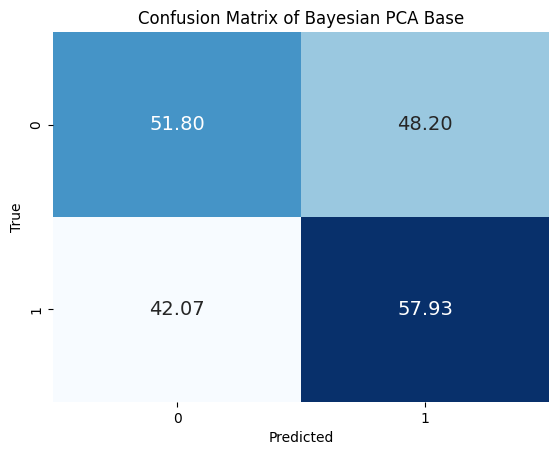

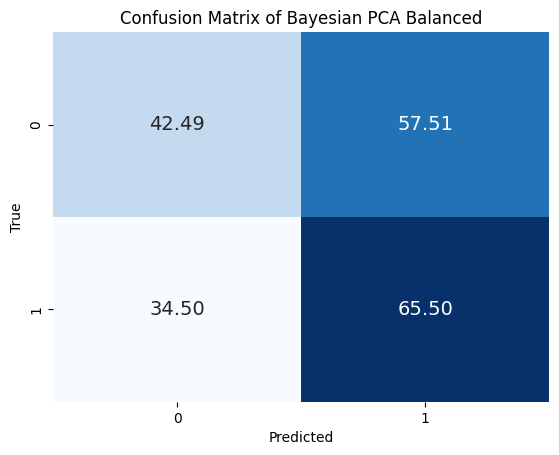

In [21]:
for idx, row in parameters.iterrows():
    model = models[ 10 + idx ]['model']
    model_name = row['Nombre']
    plot_confusion_matrix(model, X_test, y_test, model_name)

Es considerable la pérdida de desempeño que se presenta al aplicar el PCA, ya que incluso pierde capacidad para predecir adecuadamente las observaciones minoritarias, cosa que pasa en el conjuto balanceado, de manera similar al modelo anterior, además de una pérdida de 6 puntos en el AUC. Es bastante evidente que en general, el modelo no es bueno para clasificar correctamente las observaciones. 

## Comparación de Modelos

A continuación tenemos los resultados de todos los modelos básicos;

In [22]:
results = []

for idx, model_info in enumerate(models):
    model = model_info['model']
    name = model_info['name'] + (' Balanced' if idx % 2 == 1 else ' Base')
    cpu_time = model_info['cpu_time']
    
    evaluation = evaluate_model(model, X_test, y_test)
    evaluation['Name'] = name
    evaluation['CPU Time'] = cpu_time
    
    results.append(evaluation)

df_results = DataFrame(results)
df_results

,Precision,Recall,F1,AUC,Name,CPU Time
0,0.827134,0.717210,0.768260,0.642395,Logistic Base,3484.632594
1,0.828319,0.703978,0.761104,0.641237,Logistic Balanced,8085.255974
2,0.818110,0.579605,0.678508,0.612687,Logistic PCA Base,5159.598865
3,0.801951,0.699354,0.747147,0.597765,Logistic PCA Balanced,2013.703079
4,0.860359,0.754021,0.803688,0.739825,KNN Base,1925.500179
5,0.859890,0.747051,0.799509,0.735952,KNN Balanced,942.796789
6,0.861501,0.750122,0.801963,0.740496,KNN PCA Base,437.227390
7,0.864612,0.724856,0.788590,0.736895,KNN PCA Balanced,359.124776
8,0.862503,0.708400,0.777893,0.727014,Descicion Tree Base,79.125488
9,0.852014,0.807895,0.829368,0.729639,Descicion Tree Balanced,76.296319


Por tanto, el mejor modelo entre los base es:

In [23]:
max_auc_index = df_results['AUC'].idxmax()
row_with_max_auc = df_results.loc[max_auc_index]
DataFrame(row_with_max_auc).T

,Precision,Recall,F1,AUC,Name,CPU Time
6,0.861501,0.750122,0.801963,0.740496,KNN PCA Base,437.22739


No es sorpresa que a nivel general, los modelos que presentaron un mejor desempeño son los $k$-NN y los árboles de desición, teniendo tanto un buen precision como recall. Para ser más precisos, la mejor familia de modelos fueron los $k$-NN, teniendo mejores puntajes en todo. Por otro lado, los árboles de desición tienen un rendimiento similar y un tiempo de entrenamiento casi 5 veces menor que los $k$-NN por lo que también son modelos excelentes para el problema. Por otro lado, la regresión logística fue un modelo extremadamente deficiente para el excesivo tiempo que se tomó, y en el caso de la clasificación bayesiana, no importó el mínimo tiempo de entrenamiento ya que el AUC es extremadamenta pequeño.

Por último podemos ver cómo clasificó cada modelo las observaciones del set de prueba mediante los siguientes gráficos:

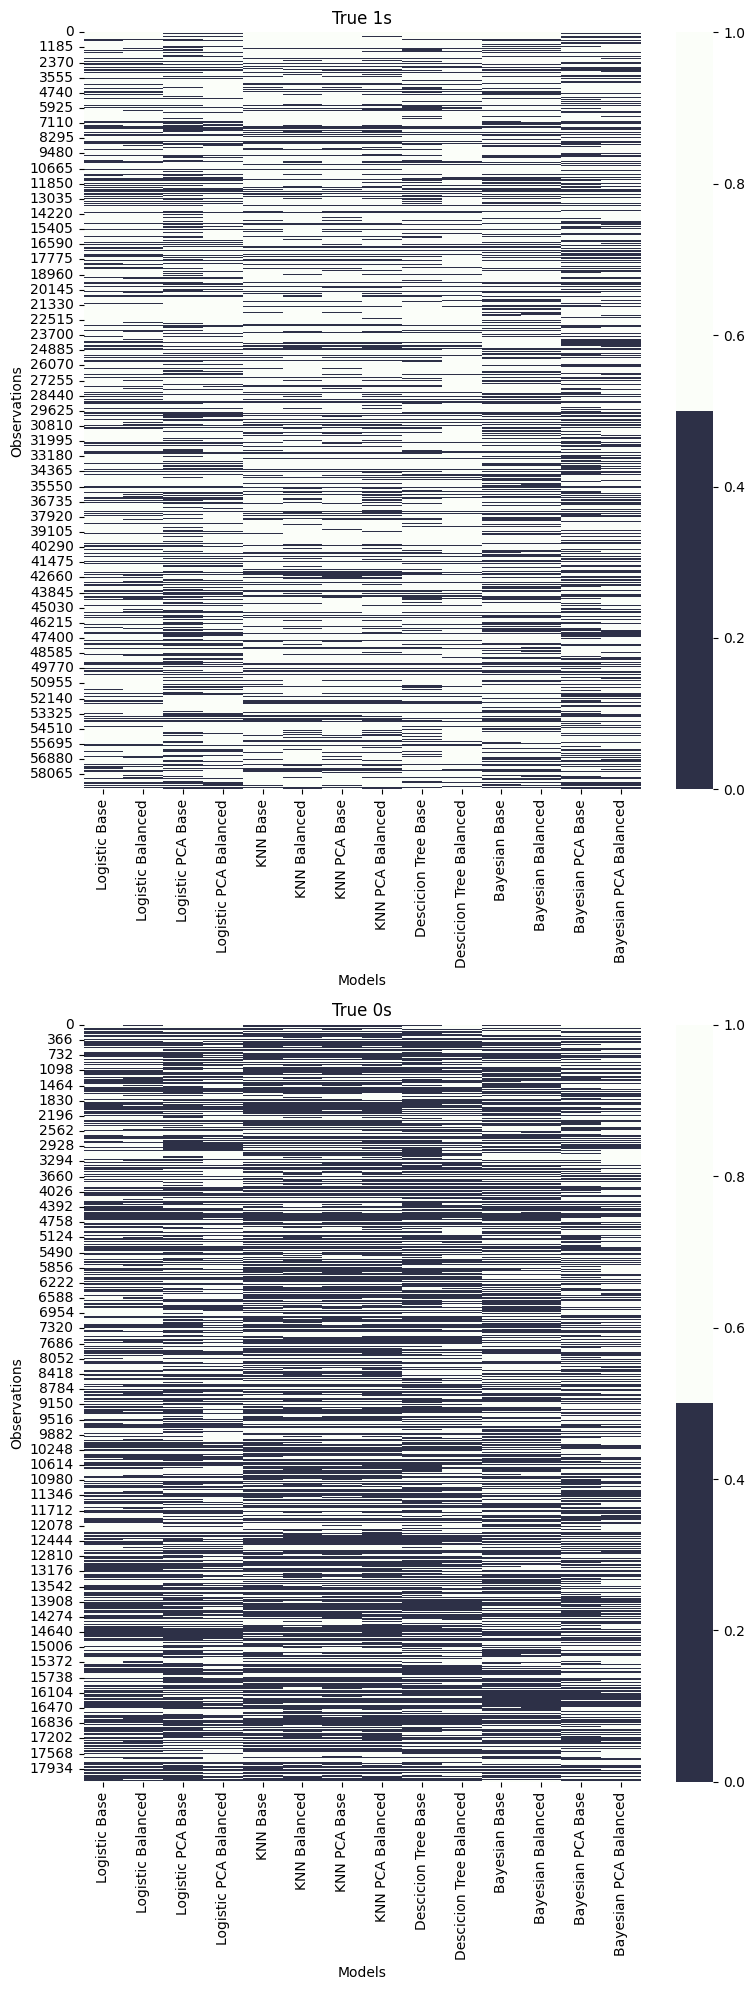

In [24]:
plot_predictions( [ model['model'] for model in models ], X_test, y_test, model_filenames, figsize = (8,20) )

Por medio de estas dos gráficas, podemos observar más claramente las observaciones anteriores, viendo que los $k$-NN tienden a clasificar correctamente cada categoría con una mayor proporción. A su vez, nos permite observar más claramente como puede funcionar uno de los modelos mejorados como lo es un sistema de votación, ya que podemos ver que hay observaciones que la mayoría de clasificadores predicen correctamente, hecho que puede suplir a aquellos modelos que clasifiquen incorrectamente. Aún así no sería perfecto, ya que en ambas gráficas se pueden ver puntos que la mayoría de modelos clasifican incorrectamente.